In [162]:
! pip install statsmodels

In [163]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# EDA

In [164]:
#Importing dataset
df = pd.read_csv("Foreign_Exchange_Rates.csv")

In [165]:
df.head()

,Unnamed: 0,Country/Currency,currency,value,date
0,0,Australia Dollar,AUD,1.581627,17-12-2021
1,1,Great Britain Pound,GBP,0.851619,17-12-2021
2,2,Euro,EUR,1.000000,17-12-2021
3,3,Japan Yen,JPY,128.301759,17-12-2021
4,4,Switzerland Franc,CHF,1.041015,17-12-2021


In [166]:
df_INR = df.loc[df.currency == 'INR']
df_INR.head()

,Unnamed: 0,Country/Currency,currency,value,date
67,67,India Rupee,INR,86.052225,17-12-2021
217,217,India Rupee,INR,85.424708,18-12-2021
367,367,India Rupee,INR,85.424708,19-12-2021
517,517,India Rupee,INR,85.497443,20-12-2021
667,667,India Rupee,INR,85.525694,21-12-2021


In [167]:
df.columns

Index(['Unnamed: 0', 'Country/Currency', 'currency', 'value', 'date'], dtype='object')

In [168]:
# Let's remove the unwanted first column
df_INR = df_INR.drop(columns=df_INR.columns[0])

In [169]:
df_INR.dtypes

Country/Currency     object
currency             object
value               float64
date                 object
dtype: object

In [170]:
# converting date to datetime64[ns] type
df_INR['date'] = pd.to_datetime(df_INR['date'], format='%d-%m-%Y', dayfirst=True)

In [171]:
#Find the duplicates
df_INR.duplicated().sum()

0

In [172]:
# As we are calculating for INR we don't need Country/Currency and currency column
df_INR = df_INR.drop(columns=df_INR.columns[:2])

In [173]:
df_INR.head()

,value,date
67,86.052225,2021-12-17
217,85.424708,2021-12-18
367,85.424708,2021-12-19
517,85.497443,2021-12-20
667,85.525694,2021-12-21


In [174]:
# We can get date month and year part from the date column
df_INR['month'] = df_INR['date'].dt.month
df_INR['year'] = df_INR['date'].dt.year
df_INR['day'] = df_INR['date'].dt.day
df_INR['day_of_week'] = df_INR['date'].dt.weekday

In [175]:
df_INR.head()

,value,date,month,year,day,day_of_week
67,86.052225,2021-12-17,12,2021,17,4
217,85.424708,2021-12-18,12,2021,18,5
367,85.424708,2021-12-19,12,2021,19,6
517,85.497443,2021-12-20,12,2021,20,0
667,85.525694,2021-12-21,12,2021,21,1


In [176]:
#Find the duplicates
df_INR.duplicated().sum()

0

In [177]:
df_INR.shape

(321, 6)

In [178]:
df_INR = df_INR.drop(['date'], axis=1)

In [179]:
df_INR.dtypes

value          float64
month            int64
year             int64
day              int64
day_of_week      int64
dtype: object

# Chaos Test - Will be adding later

# ADF Test

In [180]:
# check for Stationarity - ADF Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_INR['value'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.3001940814467954
p-value: 0.1719053840270321
Critial Values:
   1%, -3.450951662384033
Critial Values:
   5%, -2.8706147570800784
Critial Values:
   10%, -2.571604931640625


In [181]:
"""
From ADF test, it's observed that, data is not stationary. 
We can see p-value is 17% (usually it must be less than 0.05 or 5%), 
and ADF-stat value is greater than all the critical values. 

Both these values confirms the data to be Non-Stationary
"""

"\nFrom ADF test, it's observed that, data is not stationary. \nWe can see p-value is 17% (usually it must be less than 0.05 or 5%), \nand ADF-stat value is greater than all the critical values. \n\nBoth these values confirms the data to be Non-Stationary\n"

# Splitting the dataset

In [182]:
X = df_INR.iloc[:, 1:4].values
y = df_INR.iloc[:, 0].values

In [183]:
X.shape

(321, 3)

In [184]:
y.shape

(321,)

In [185]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [186]:
# SMAPE function - Symmetric mean absolute percentage error
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [187]:
# Direction Symmetry - It gives the percentage of occurrences in which the sign of the change in value from one time period to the next is the same for both the actual and predicted time series
def ds(A, F):
    sum_A = 0
    for i in range(1, len(A)):
        sum_A += 1 if (A[i]-A[i-1])*(F[i]-F[i-1])>0 else 0
    return (100*sum_A)/(len(A)-1)

In [188]:
# Theil's U coefficient - The greater accuracy of the forecast, the lower will be the value of the u1
def u1(A,F):
    data = pd.DataFrame({'A_i':A, 'F_i': F})
    data['(A_i - F_i)^2'] = np.square(data['A_i'] - data['F_i'])
    data['F_i^2'] = np.square(data['F_i'])
    data['A_i^2'] = np.square(data['A_i'])
    return (np.sqrt(np.mean(data['(A_i - F_i)^2'])))/(np.sqrt(np.mean(data['F_i^2']))+np.sqrt(np.mean(data['A_i^2'])))

# Linear Regression

In [189]:
# Fitting Linear Regression in dataset
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [190]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.7425229758512142
MSE 1.1031253021980656
RMSE 1.0502977207430595


 SMAPE prediction

In [191]:
print(smape(y_test, y_pred))

1.0363194024323275


 Direction Symmetry prediction

In [192]:
print(ds(y_test, y_pred))

81.25


 Theil's U coefficient prediction

In [193]:
print(u1(y_test, y_pred))

0.006363098882502299


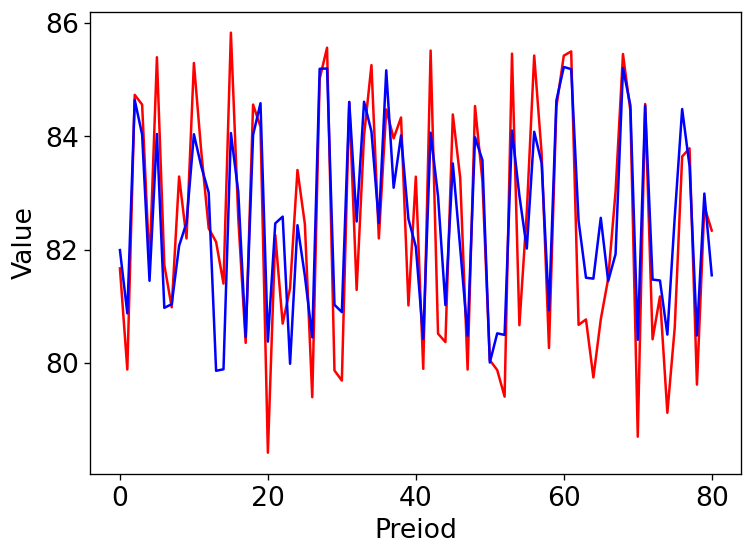

In [194]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# Polynomial Regression

In [195]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': np.arange(20), 'linearregression__fit_intercept': [True, False]}

search = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring='neg_mean_squared_error').fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 5}


In [196]:
# Fitting Polynomial Regression in dataset

poly = PolynomialFeatures(degree=search.best_params_["polynomialfeatures__degree"], include_bias=True)
X_train_trans = poly.fit_transform(X_train)
X_test_trans = poly.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_trans, y_train)
y_pred = lr.predict(X_test_trans)

In [197]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.8454529610998622
MSE 0.6621357752372279
RMSE 0.8137172575515575


 SMAPE prediction

In [198]:
print(smape(y_test, y_pred))

0.7150444450625947


 Direction Symmetry prediction

In [199]:
print(ds(y_test, y_pred))

88.75


 Theil's U coefficient prediction

In [200]:
print(u1(y_test, y_pred))

0.0049304747999787644


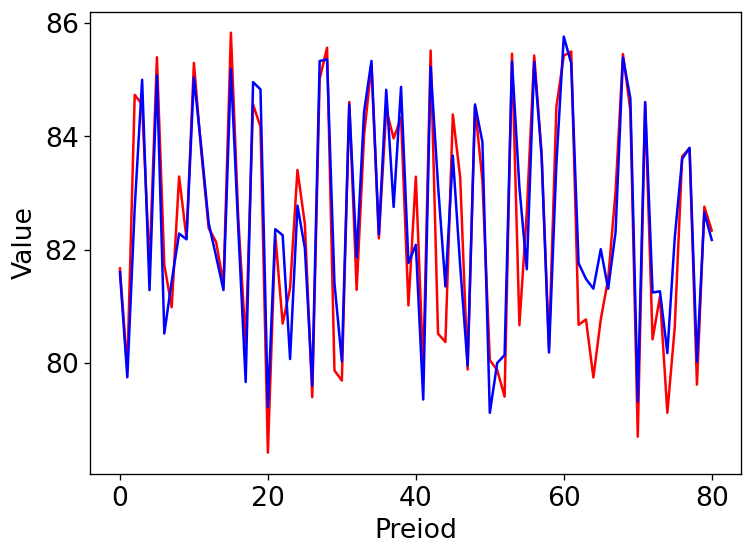

In [201]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# Decision Tree Regression

In [202]:
# Fitting Decision Tree Regression in dataset
from sklearn.tree import DecisionTreeRegressor 

regressor = DecisionTreeRegressor(random_state = 0) 

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [203]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.9492469560490063
MSE 0.21744451618937033
RMSE 0.46630946397148143


 SMAPE prediction

In [204]:
print(smape(y_test, y_pred))

0.39638661461300856


 Direction Symmetry prediction

In [205]:
print(ds(y_test, y_pred))

93.75


 Theil's U coefficient prediction

In [206]:
print(u1(y_test, y_pred))

0.002826092605769641


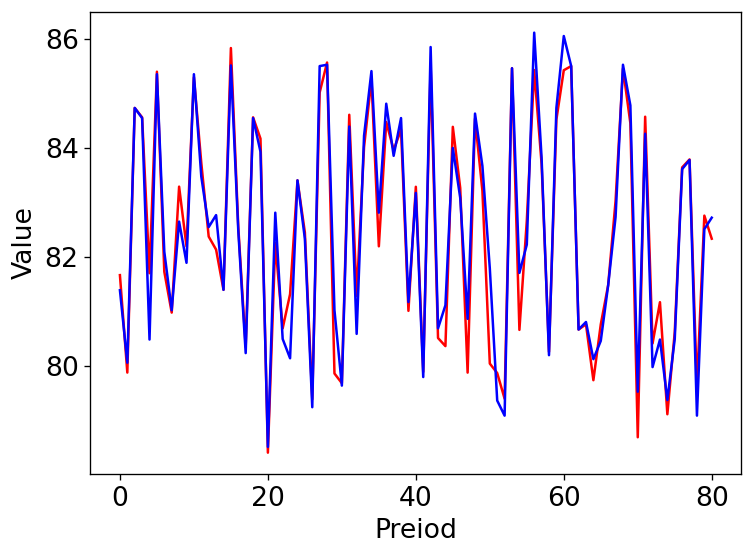

In [207]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

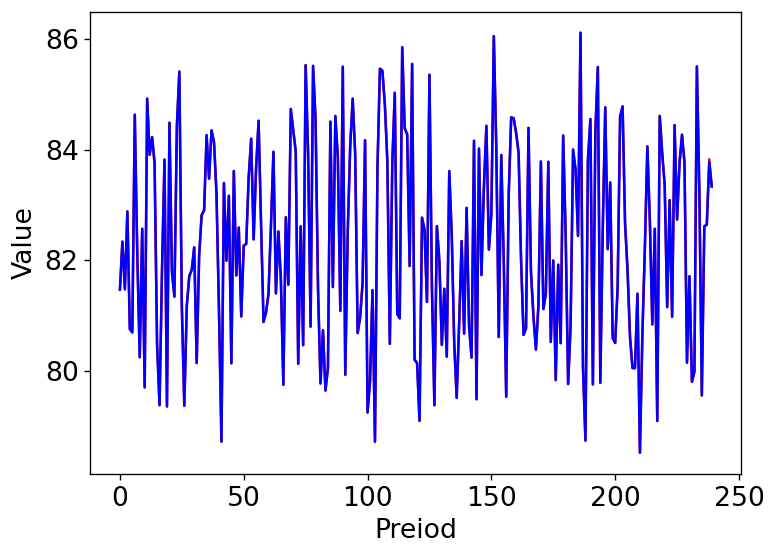

In [208]:
# It is overfitted
plt.rc("figure")
plt.plot(y_train, color="r")
plt.plot(regressor.predict(X_train), color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# Random Forest Regression

In [209]:
from sklearn.ensemble import RandomForestRegressor

In [210]:
model = RandomForestRegressor()

In [211]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [3, 4],
              "n_estimators": [100, 300, 1000]}

# try out every combination of the above values
search = GridSearchCV(model, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'max_depth': 4, 'n_estimators': 100}


In [212]:
# Fitting Random Forest Regression in dataset
regressor = RandomForestRegressor(n_estimators  = search.best_params_["n_estimators"],
                                   max_depth     = search.best_params_["max_depth"])

regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)

In [213]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.837875378894378
MSE 0.6946008959134911
RMSE 0.8334271989283113


 SMAPE prediction

In [214]:
print(smape(y_test, y_pred))

0.7985585707735982


 Direction Symmetry prediction

In [215]:
print(ds(y_test, y_pred))

87.5


 Theil's U coefficient prediction

In [216]:
print(u1(y_test, y_pred))

0.005048692659369964


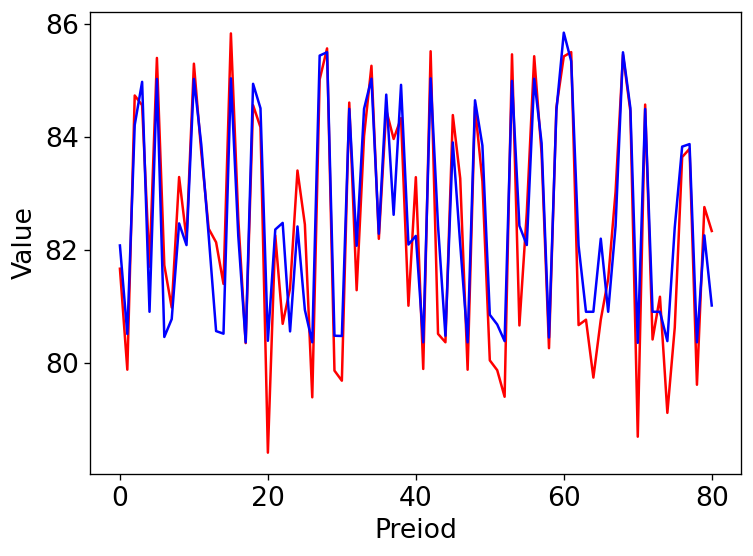

In [217]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

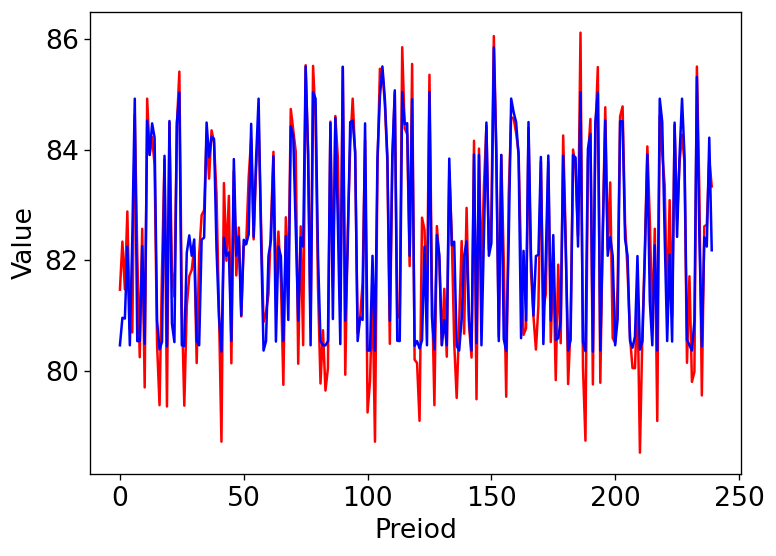

In [218]:
# It is not overfitted
plt.rc("figure")
plt.plot(y_train, color="r")
plt.plot(regressor.predict(X_train), color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# XGB Regression

In [219]:
from xgboost import XGBRegressor

In [220]:
model = XGBRegressor()

In [221]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
              "n_estimators": [100, 300, 1000],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(model, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 5, 'n_estimators': 1000}


In [222]:
regressor = XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [223]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.9543727567961364
MSE 0.19548371981587556
RMSE 0.4421354089143682


 SMAPE prediction

In [224]:
print(smape(y_test, y_pred))

0.42014039206996645


 Direction Symmetry prediction

In [225]:
print(ds(y_test, y_pred))

91.25


 Theil's U coefficient prediction

In [226]:
print(u1(y_test, y_pred))

0.0026791443260898284


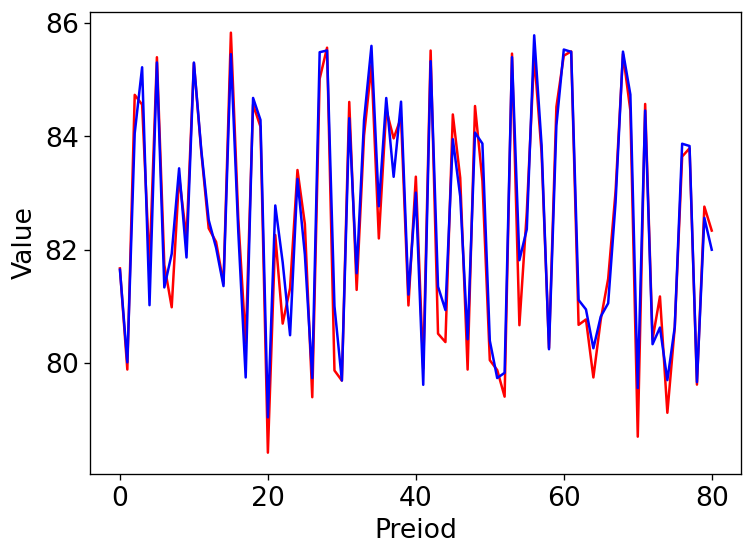

In [227]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# SGD Regression

In [228]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [229]:
from sklearn.pipeline import Pipeline

# Create a Pipeline object
sgd_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor()),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'sgd__alpha': [0.5, 0.3, 0.2, 0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': np.arange(0, 1.1, 0.1), 
              'sgd__max_iter':[100, 200, 500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001],
              'sgd__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
              'sgd__warm_start': [True, False]
            }

# Create a GridSearchCV object and perform hyperparameter tuning
sgdr = GridSearchCV(sgd_pipeline, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgdr.fit(X_train, y_train)

# Get the optimal hyperparameters
params_optimal_sgdr = sgdr.best_params_

print("Best Score (negative mean squared error): %f" % sgdr.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgdr)

Fitting 3 folds for each of 7392 candidates, totalling 22176 fits
Best Score (negative mean squared error): -0.837372
Optimal Hyperparameter Values:  {'sgd__alpha': 0.01, 'sgd__eta0': 0.01, 'sgd__l1_ratio': 1.0, 'sgd__learning_rate': 'optimal', 'sgd__max_iter': 200, 'sgd__warm_start': True}


In [230]:
y_pred = sgdr.predict(X_test)

In [231]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.7459682864135079
MSE 1.0883643375342822
RMSE 1.0432470165470316


 SMAPE prediction

In [232]:
print(smape(y_test, y_pred))

1.0295644137457387


 Direction Symmetry prediction

In [233]:
print(ds(y_test, y_pred))

81.25


 Theil's U coefficient prediction

In [234]:
print(u1(y_test, y_pred))

0.006322551510700199


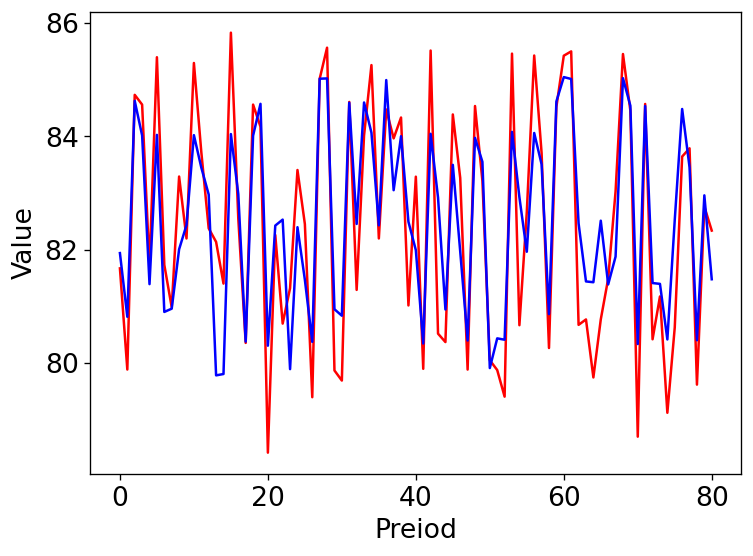

In [235]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# LSTM

In [236]:
# Splitting the dataset into the Training set and Test set
X = df_INR.iloc[:, 1:].values
y = df_INR.iloc[:, 0].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [237]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler

sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = MinMaxScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1,1))

In [238]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [239]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, 4)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 100)            42000     
                                                                 
 dense_6 (Dense)             (None, 1, 1)              101       
                                                                 
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________


In [240]:
# fit model
X_train = np.reshape(X_train, (X_train.shape[0], 1, 4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 4))
history = model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=1, validation_split=0.1)

Epoch 1/5
216/216 [==============================] - 5s 8ms/step - loss: 0.0986 - val_loss: 0.0580
Epoch 2/5
216/216 [==============================] - 1s 5ms/step - loss: 0.0611 - val_loss: 0.0480
Epoch 3/5
216/216 [==============================] - 1s 5ms/step - loss: 0.0424 - val_loss: 0.0316
Epoch 4/5
216/216 [==============================] - 1s 5ms/step - loss: 0.0264 - val_loss: 0.0152
Epoch 5/5
216/216 [==============================] - 1s 5ms/step - loss: 0.0181 - val_loss: 0.0121


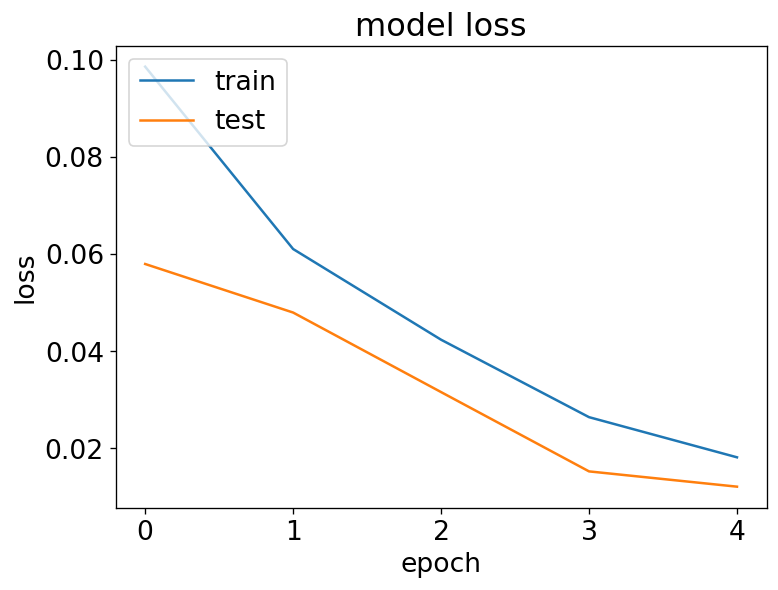

In [241]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [242]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
test_predict = sc_y.inverse_transform(test_predict.reshape(-1,1))

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

3/3 [==============================] - 0s 7ms/step
Shape of train and test predict:  (240, 1, 1) (81, 1)


In [243]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(y_train, train_predict.reshape(-1,1))
test_score = measure_rmse(y_test, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

Train and Test RMSE:  0.11959052252090373 1.0849396191261422


In [244]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.7459682864135079
MSE 1.0883643375342822
RMSE 1.0432470165470316


 SMAPE prediction

In [245]:
print(smape(y_test, y_pred))

1.0295644137457387


 Direction Symmetry prediction

In [246]:
print(ds(y_test, y_pred))

81.25


 Theil's U coefficient prediction

In [247]:
print(u1(y_test, y_pred))

0.006322551510700199


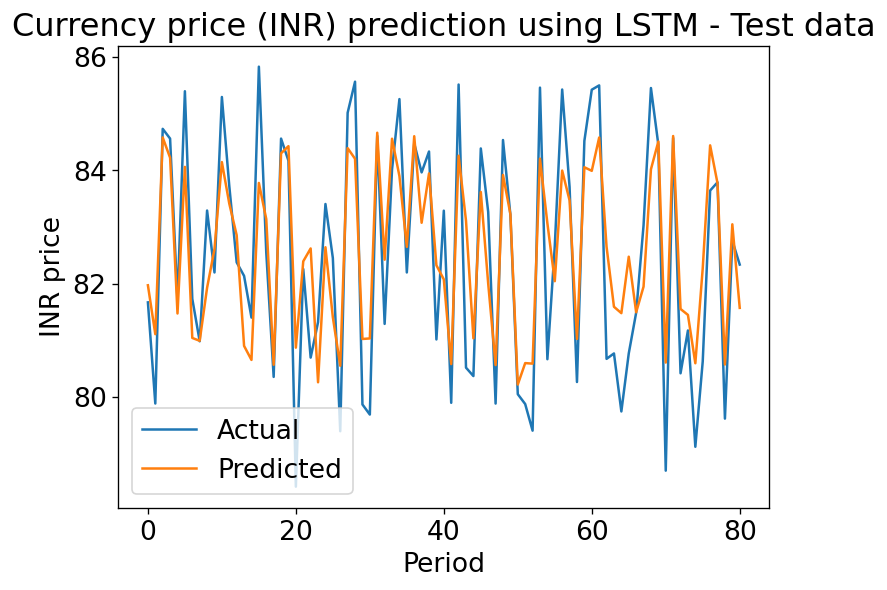

In [248]:
plt.rc("figure")
plt.rcParams.update({'font.size': 16})
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Period')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

# ANN 1-10-1

In [249]:
#Importing dataset
df = pd.read_csv("Foreign_Exchange_Rates.csv")
df_INR = df.loc[df.currency == 'INR']
df_INR['date'] = pd.to_datetime(df_INR['date'], format='%d-%m-%Y', dayfirst=True)
df_INR.head()

,Unnamed: 0,Country/Currency,currency,value,date
67,67,India Rupee,INR,86.052225,2021-12-17
217,217,India Rupee,INR,85.424708,2021-12-18
367,367,India Rupee,INR,85.424708,2021-12-19
517,517,India Rupee,INR,85.497443,2021-12-20
667,667,India Rupee,INR,85.525694,2021-12-21


In [250]:
# Splitting the dataset
X = df_INR.iloc[:, -1:].values
y = df_INR.iloc[:, -2].values

In [251]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Feature scaling
from sklearn.preprocessing import MinMaxScaler

sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = MinMaxScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1,1))

In [252]:
from keras.models import Sequential
from keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(10, activation = 'relu', input_dim = 1))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 10)                20        
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [253]:
# fit model
history = model.fit(X_train, y_train, epochs=25, batch_size=10, verbose=1, validation_split=0.1)

Epoch 1/25
22/22 [==============================] - 2s 25ms/step - loss: 0.0455 - val_loss: 0.0459
Epoch 2/25
22/22 [==============================] - 0s 7ms/step - loss: 0.0430 - val_loss: 0.0432
Epoch 3/25
22/22 [==============================] - 0s 9ms/step - loss: 0.0412 - val_loss: 0.0413
Epoch 4/25
22/22 [==============================] - 0s 9ms/step - loss: 0.0398 - val_loss: 0.0395
Epoch 5/25
22/22 [==============================] - 0s 11ms/step - loss: 0.0384 - val_loss: 0.0381
Epoch 6/25
22/22 [==============================] - 0s 8ms/step - loss: 0.0371 - val_loss: 0.0368
Epoch 7/25
22/22 [==============================] - 0s 7ms/step - loss: 0.0358 - val_loss: 0.0356
Epoch 8/25
22/22 [==============================] - 0s 8ms/step - loss: 0.0347 - val_loss: 0.0343
Epoch 9/25
22/22 [==============================] - 0s 8ms/step - loss: 0.0335 - val_loss: 0.0332
Epoch 10/25
22/22 [==============================] - 0s 9ms/step - loss: 0.0325 - val_loss: 0.0323
Epoch 11/25
22/22

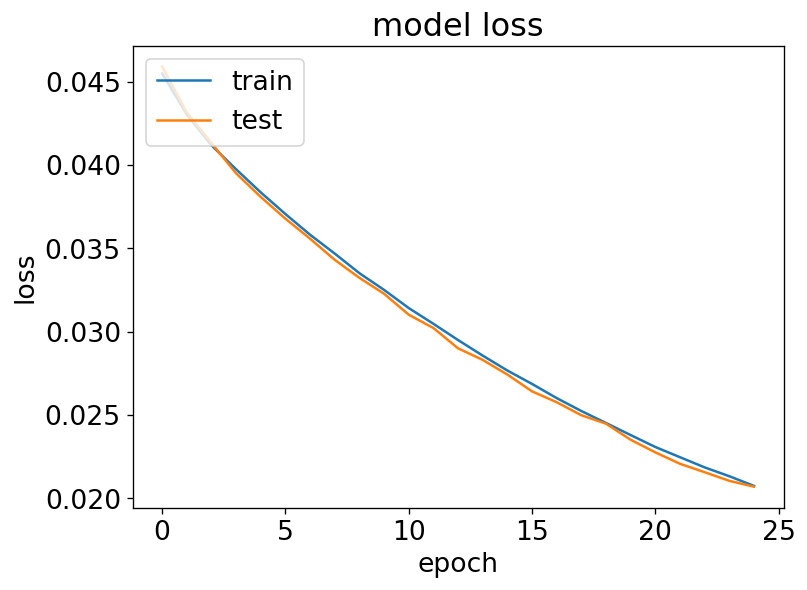

In [254]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [255]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
test_predict = sc_y.inverse_transform(test_predict)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

3/3 [==============================] - 0s 0s/step
Shape of train and test predict:  (240, 1) (81, 1)


In [256]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(y_train, train_predict)
test_score = measure_rmse(y_test, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

Train and Test RMSE:  0.14320326520803617 1.308708953326333


In [257]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, test_predict))
print("MSE", mean_squared_error(y_test, test_predict))
print("RMSE", math.sqrt(mean_squared_error(y_test, test_predict)))

R2 score:  0.7459682864135079
MSE 1.0883643375342822
RMSE 1.0432470165470316


 SMAPE prediction

In [258]:
print(smape(y_test, test_predict))

1.0295644137457387


 Direction Symmetry prediction

In [259]:
print(ds(y_test, test_predict))

81.25


 Theil's U coefficient prediction

In [260]:
print(u1(y_test, test_predict))

0.006322551510700199


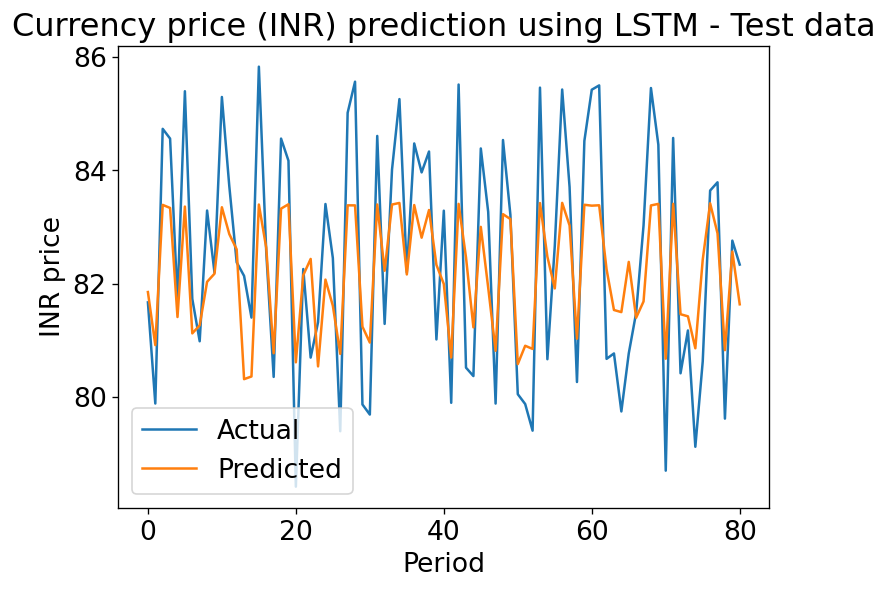

In [261]:
plt.rc("figure")
plt.rcParams.update({'font.size': 16})
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Period')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

# SARIMA

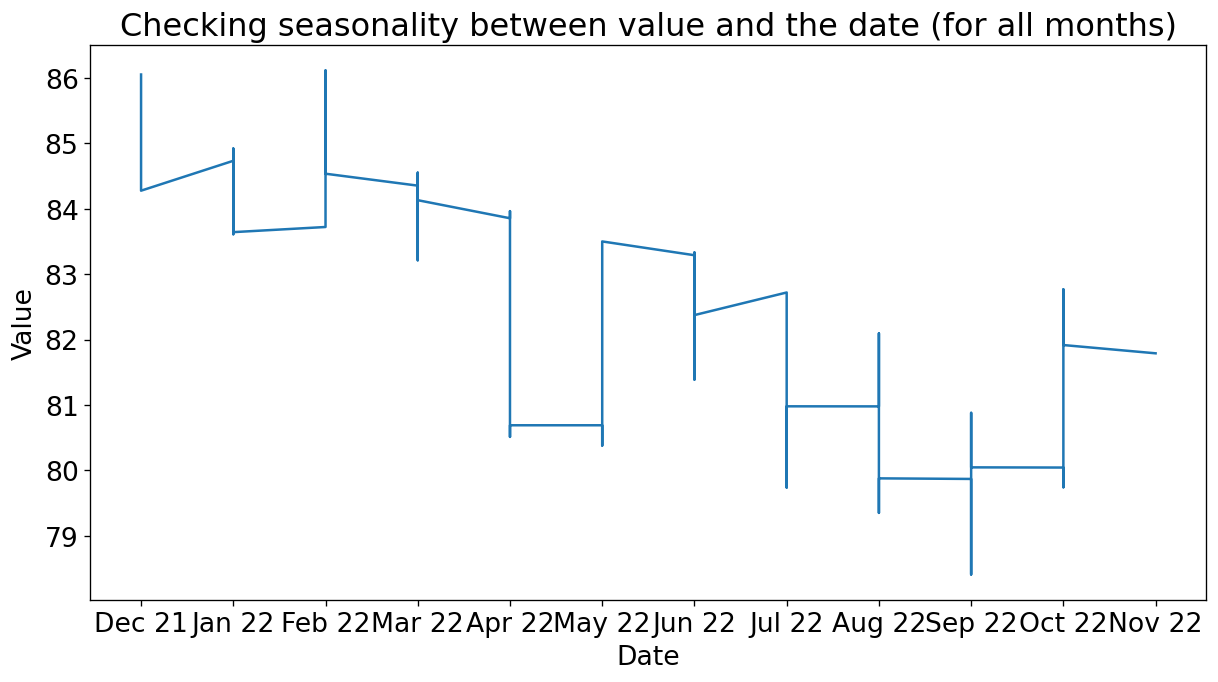

In [262]:
# Analysing for seasonality
from datetime import datetime
INR_dataset = df.loc[df.currency == 'INR']
Date_column = [datetime.strptime(d, '%d-%m-%Y').strftime("%b %y") for d in INR_dataset['date']]
Day_column = [datetime.strptime(d, '%d-%m-%Y').strftime("%A") for d in INR_dataset['date']]

# Let's check for all the months for the exchange rate currency values in india
plt.figure(figsize=(12,6))
plt.plot(Date_column, INR_dataset['value'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for all months)')
plt.show()

The graph is neither increasing or decreasing based on the months. So, let's check it for a particular week.

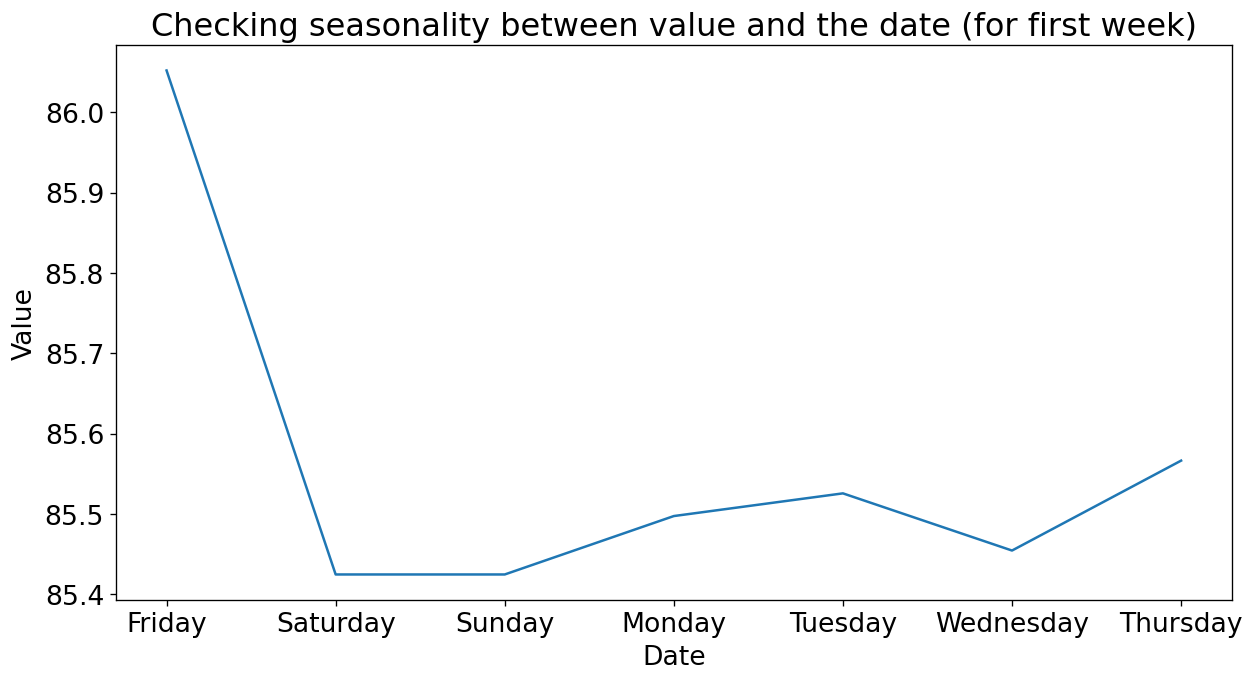

In [263]:
plt.figure(figsize=(12,6))
plt.plot(Day_column[:7], INR_dataset['value'][:7])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for first week)')
plt.show()

In week we get to see that the friday has the highest currency rate and it decreases as we move to weekends. So, let's check for multiple weeks and figure out about the days at which we get the higher currency rate from all the week days.

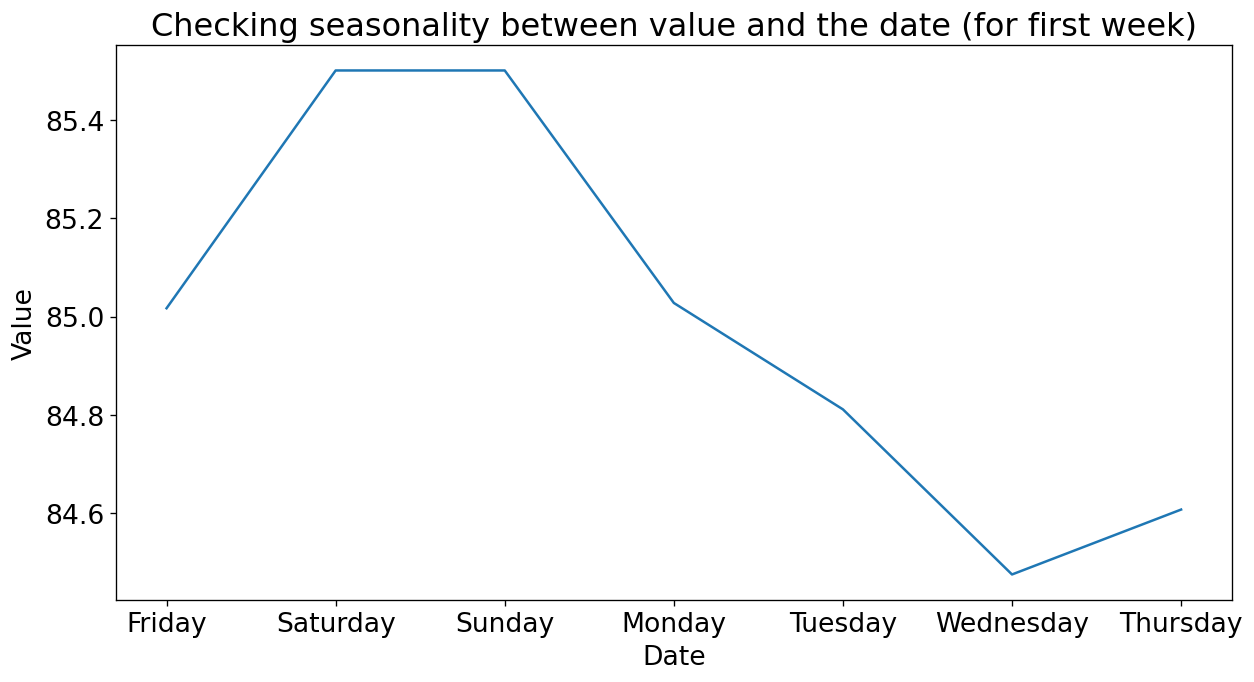

In [283]:
plt.figure(figsize=(12,6))
plt.plot(Day_column[7:14], INR_dataset['value'][7:14])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for first week)')
plt.show()

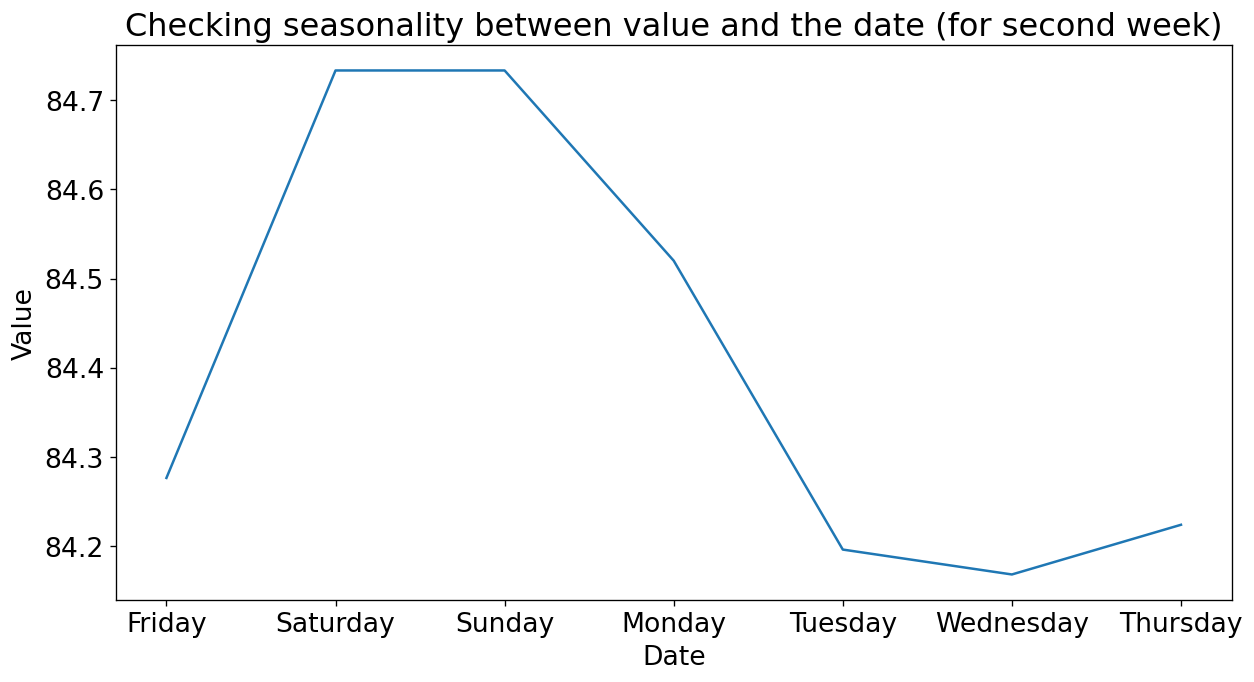

In [284]:
plt.figure(figsize=(12,6))
plt.plot(Day_column[14:21], INR_dataset['value'][14:21])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for second week)')
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, '17-12-2021'),
  Text(1, 0, '18-12-2021'),
  Text(2, 0, '19-12-2021'),
  Text(3, 0, '20-12-2021'),
  Text(4, 0, '21-12-2021'),
  Text(5, 0, '22-12-2021'),
  Text(6, 0, '23-12-2021'),
  Text(7, 0, '24-12-2021'),
  Text(8, 0, '25-12-2021'),
  Text(9, 0, '26-12-2021'),
  Text(10, 0, '27-12-2021'),
  Text(11, 0, '28-12-2021'),
  Text(12, 0, '29-12-2021'),
  Text(13, 0, '30-12-2021'),
  Text(14, 0, '31-12-2021'),
  Text(15, 0, '01-01-2022'),
  Text(16, 0, '02-01-2022'),
  Text(17, 0, '03-01-2022'),
  Text(18, 0, '04-01-2022'),
  Text(19, 0, '05-01-2022'),
  Text(20, 0, '06-01-2022')])

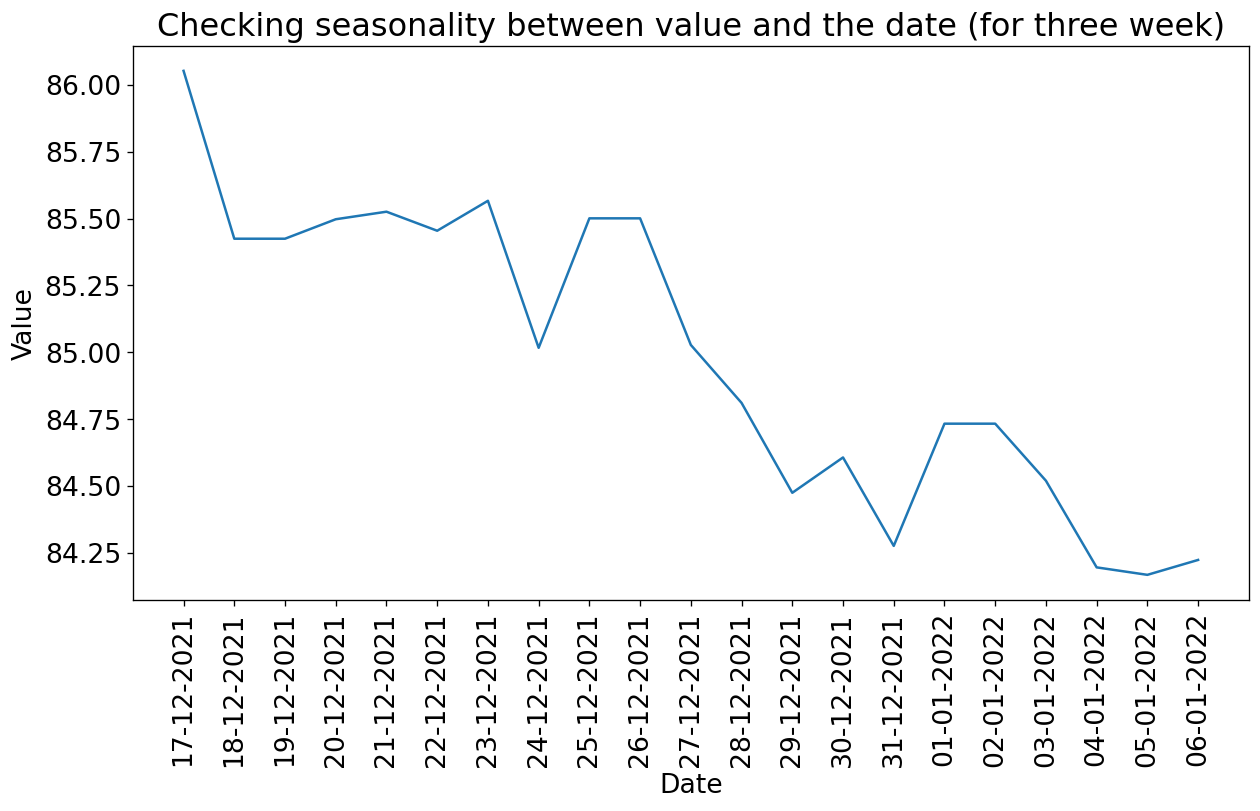

In [266]:
plt.figure(figsize=(12,6))
plt.plot(INR_dataset['date'][:21], INR_dataset['value'][:21])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for three week)')
plt.xticks(rotation=90)

As, we can see in the graph the rate of currency increases highly when we move from the december 31st, 2021 to January 1st 2022 and same when we have festivals like the currency rate rapidly increased when we have christmas on 25th or 26th december. 
Hence, SARIMA can help us to predict ouput currency rate based on the seasonality. 

In [267]:
INR_dataset = INR_dataset.set_index('date')

In [268]:
INR_dataset.dtypes

Unnamed: 0            int64
Country/Currency     object
currency             object
value               float64
dtype: object

In [269]:
INR_dataset = INR_dataset.iloc[:, -1:]
INR_dataset.head()

,value
date,
17-12-2021,86.052225
18-12-2021,85.424708
19-12-2021,85.424708
20-12-2021,85.497443
21-12-2021,85.525694


We have to calculate p, d, q, P, D, and Q value for the SARIMA to make the model for our forecasting

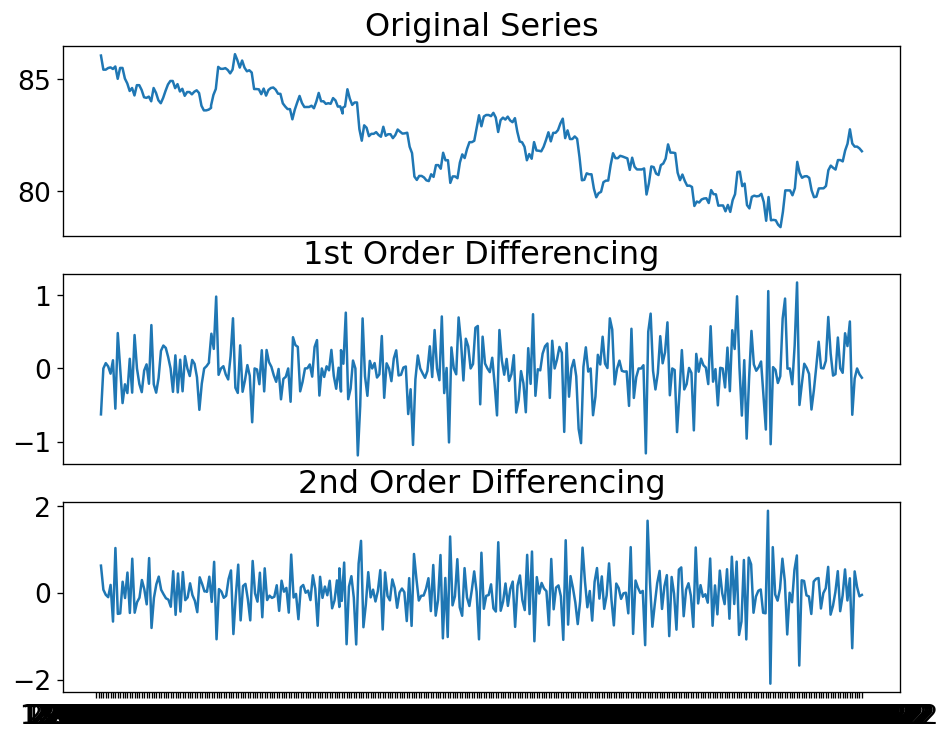

In [270]:
# Finding the d value
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(INR_dataset.value); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(INR_dataset.value.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(INR_dataset.value.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

In the first order differencing we have few noises than the second order differencing. So, we select the first order differencing for the model

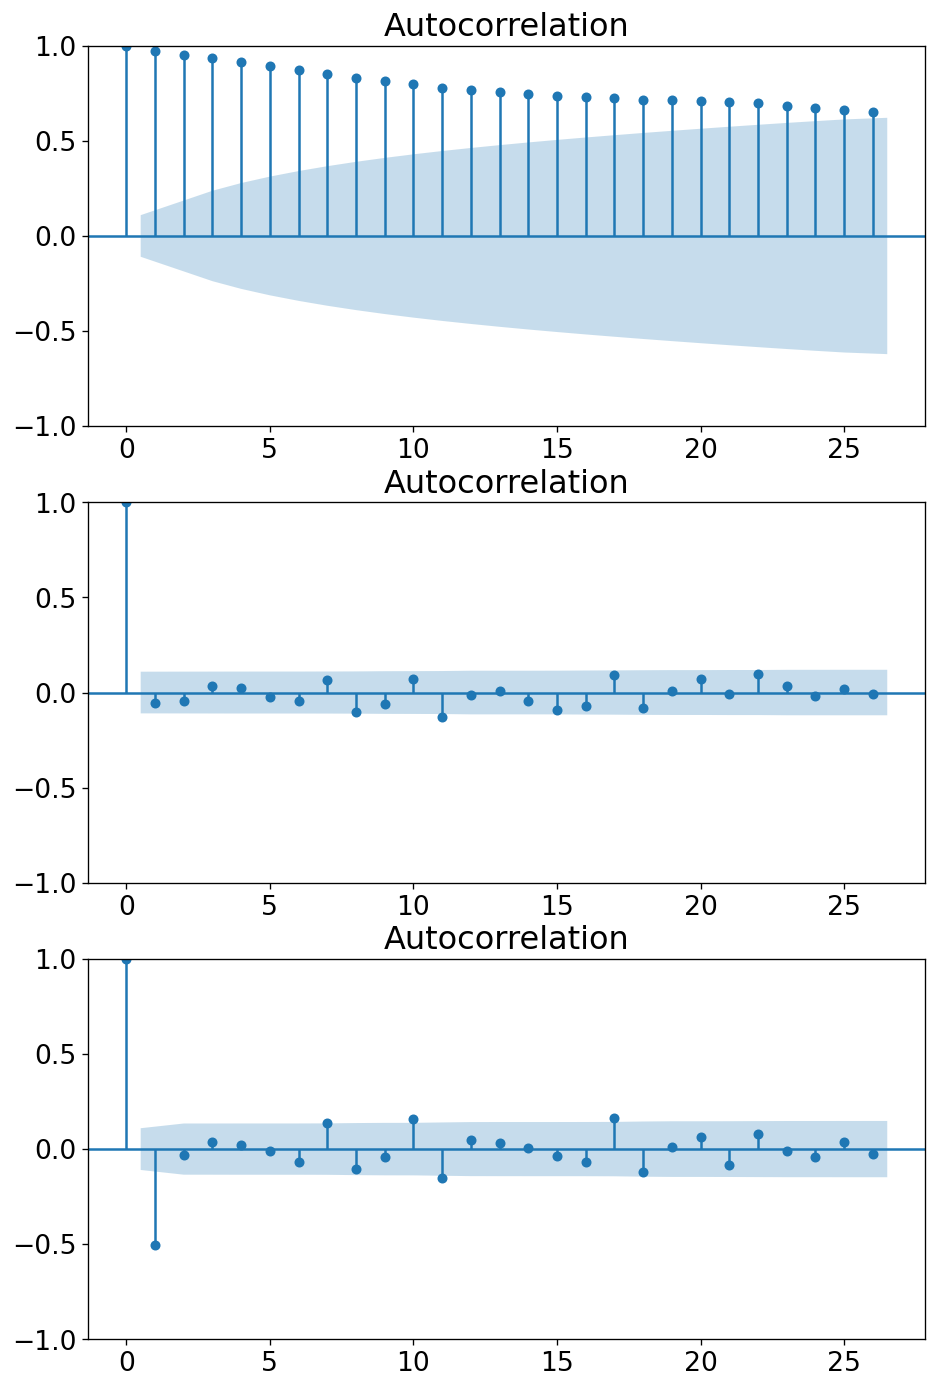

In [271]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams.update({'figure.figsize':(9,14), 'figure.dpi':120})
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(INR_dataset.value, ax=ax1)
plot_acf(INR_dataset.value.diff().dropna(), ax=ax2)
plot_acf(INR_dataset.value.diff().diff().dropna(), ax=ax3)
plt.show()

Here we can see that the second order differencing the immediate lag is gone to the negative side, representing that in second order the series has become over the difference.
Hence d = 1.

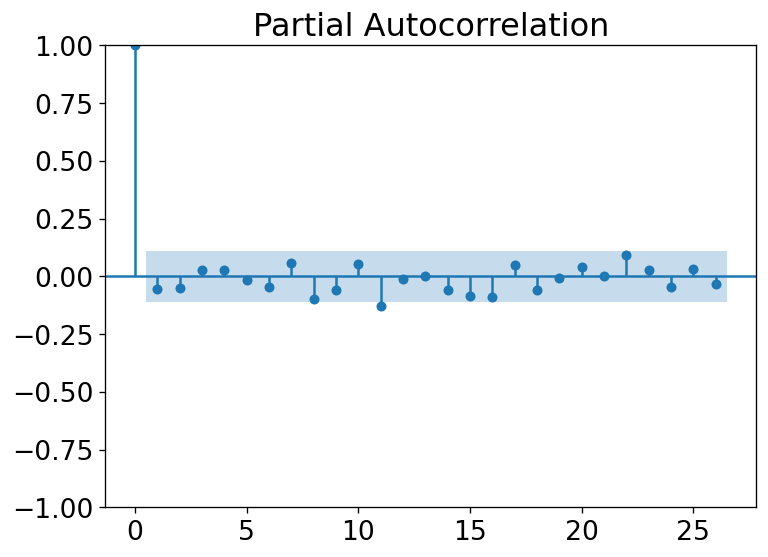

In [272]:
#Finding the p value
from statsmodels.graphics.tsaplots import plot_pacf

plt.rcParams.update({'figure.figsize':(7, 5), 'figure.dpi':120})
plot_pacf(INR_dataset.value.diff().dropna(), method='ywm')
plt.show()

Here we can see that the first lag is most significant than any other lags in the graph.
Hence p = 1.

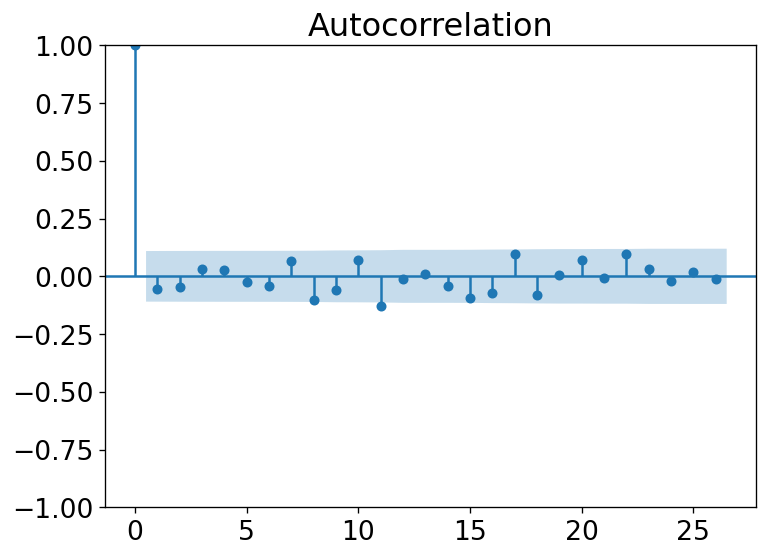

In [273]:
# Finding the q value

plot_acf(INR_dataset.value.diff().dropna())
plt.show()

Here we can see that only 1 of the lag is out of significant limit.
Hence q = 1.

In [274]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(INR_dataset['value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(dis=-1)
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  321
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -151.371
Date:                            Wed, 05 Jul 2023   AIC                            312.741
Time:                                    18:19:10   BIC                            331.392
Sample:                                         0   HQIC                           320.199
                                            - 321                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2826      0.979      0.289      0.773      -1.637       2.202
ma.L1         -0.3376      0.963   

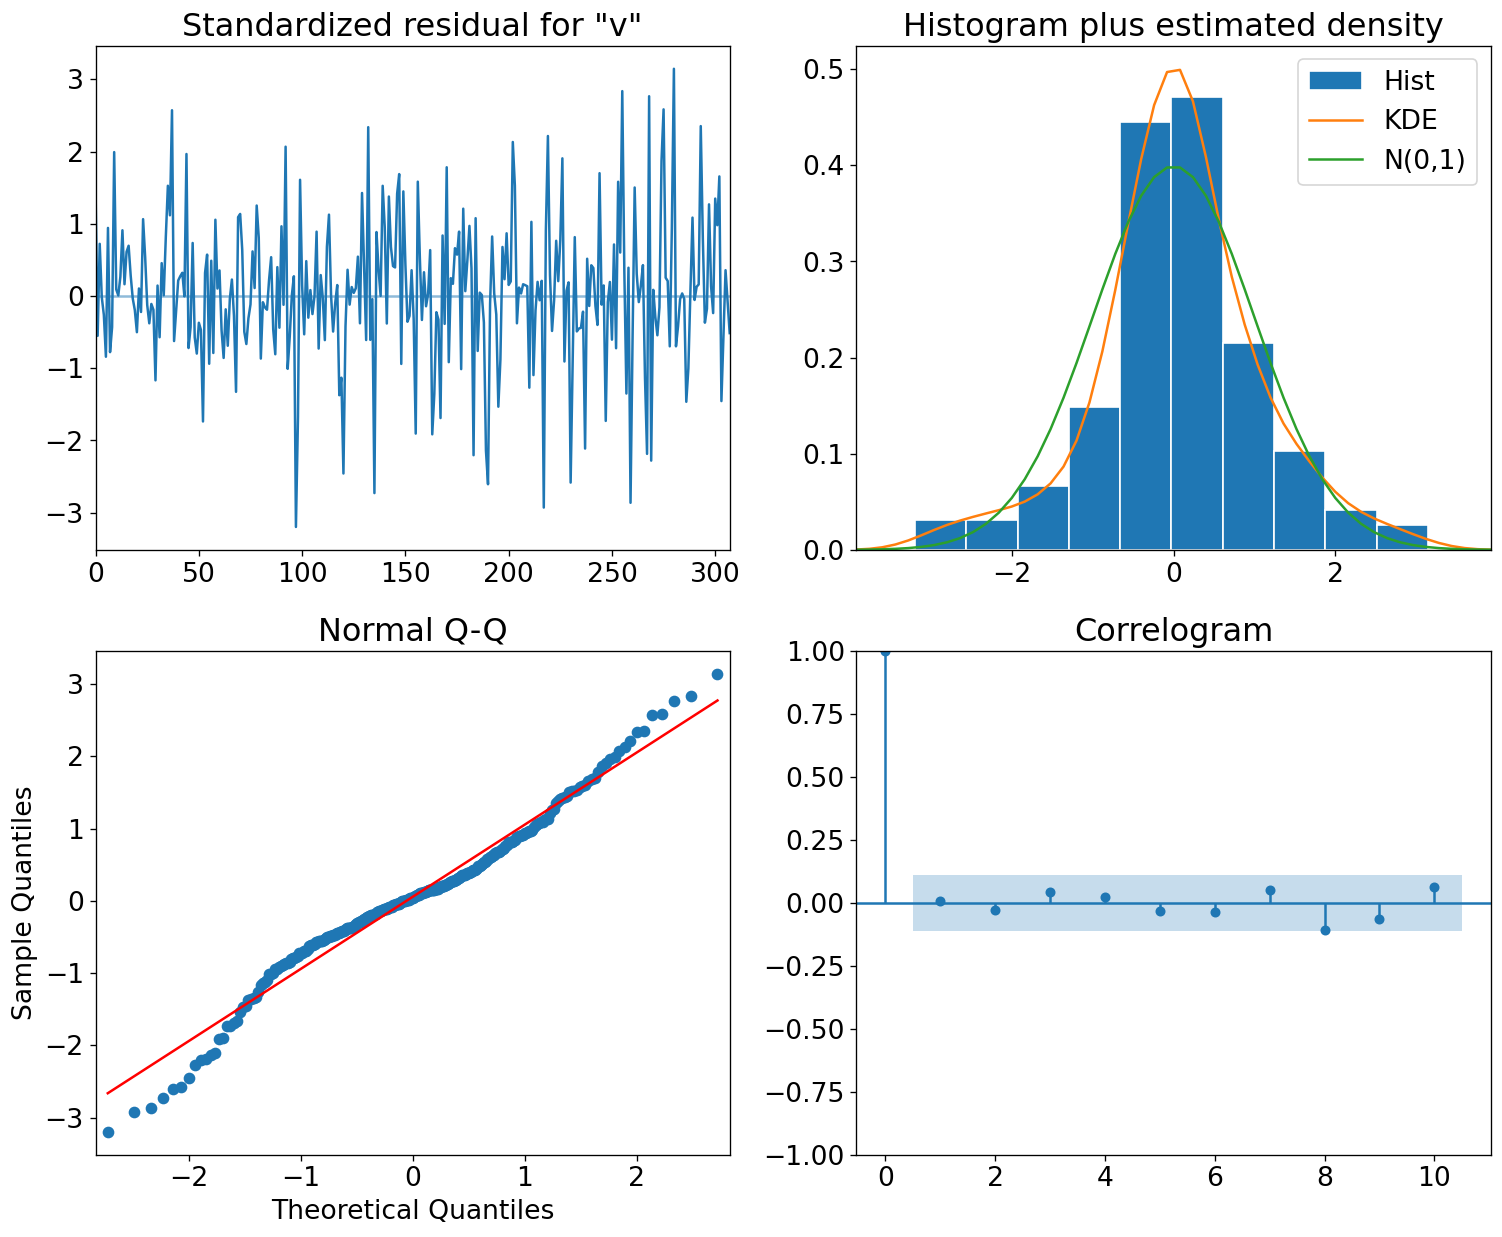

In [275]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

In [276]:
INR_dataset = df.loc[df.currency == 'INR']

In [277]:
INR_dataset = INR_dataset.iloc[:, -2:]
INR_dataset.head()

,value,date
67,86.052225,17-12-2021
217,85.424708,18-12-2021
367,85.424708,19-12-2021
517,85.497443,20-12-2021
667,85.525694,21-12-2021


In [278]:
INR_dataset = INR_dataset.reset_index()

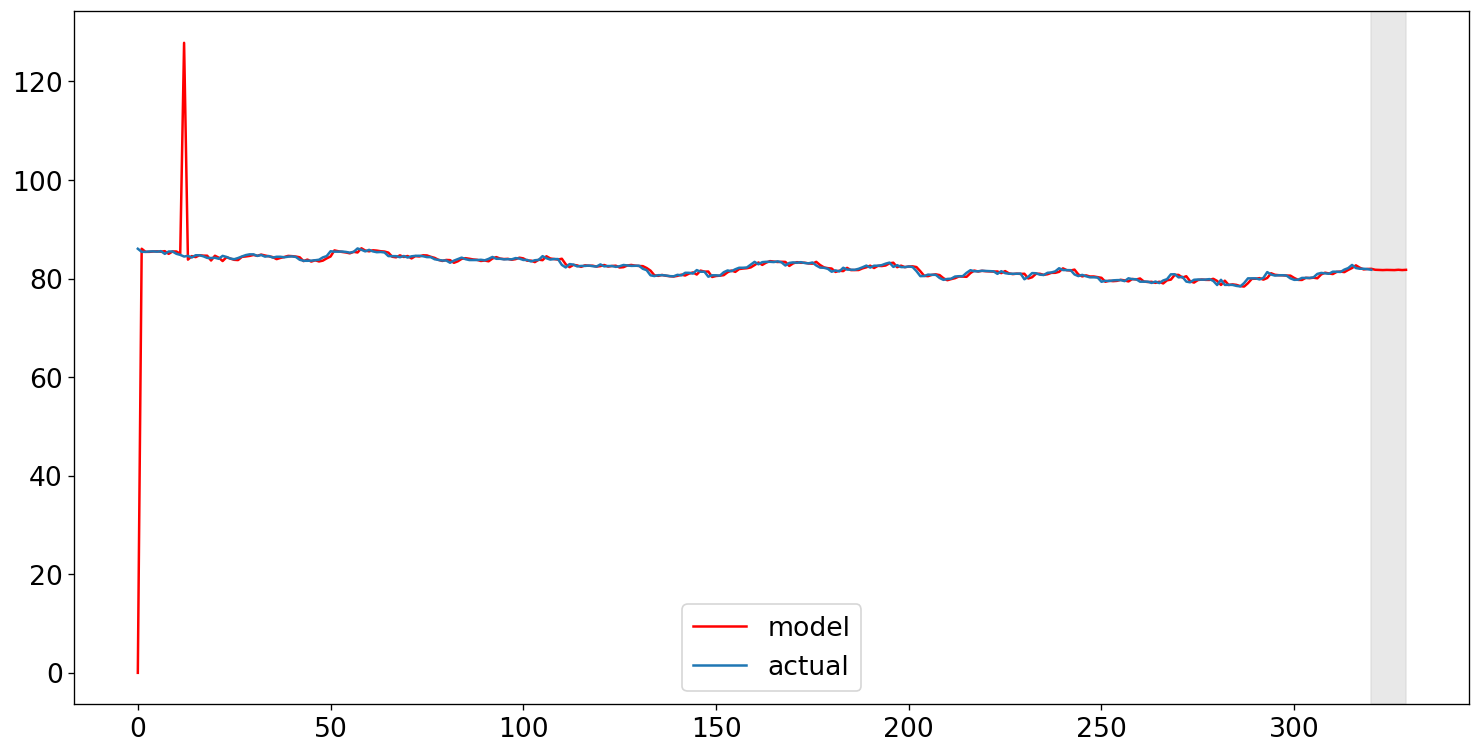

In [279]:
forecast = model.predict(start=0, end=INR_dataset.shape[0] + 8)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(INR_dataset.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(INR_dataset['value'], label='actual')
plt.legend()
plt.show()

In [280]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

train = INR_dataset[:int(0.85*(len(INR_dataset)))]
test = INR_dataset[int(0.85*(len(INR_dataset))):]

start=len(train)
end=len(train)+len(test)-1
predictions = model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['value'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['value'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['value'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['value'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['value'])
                                                               /np.abs(test['value']))*100 
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.813455,0.328729,0.214923,0.463598,NaN


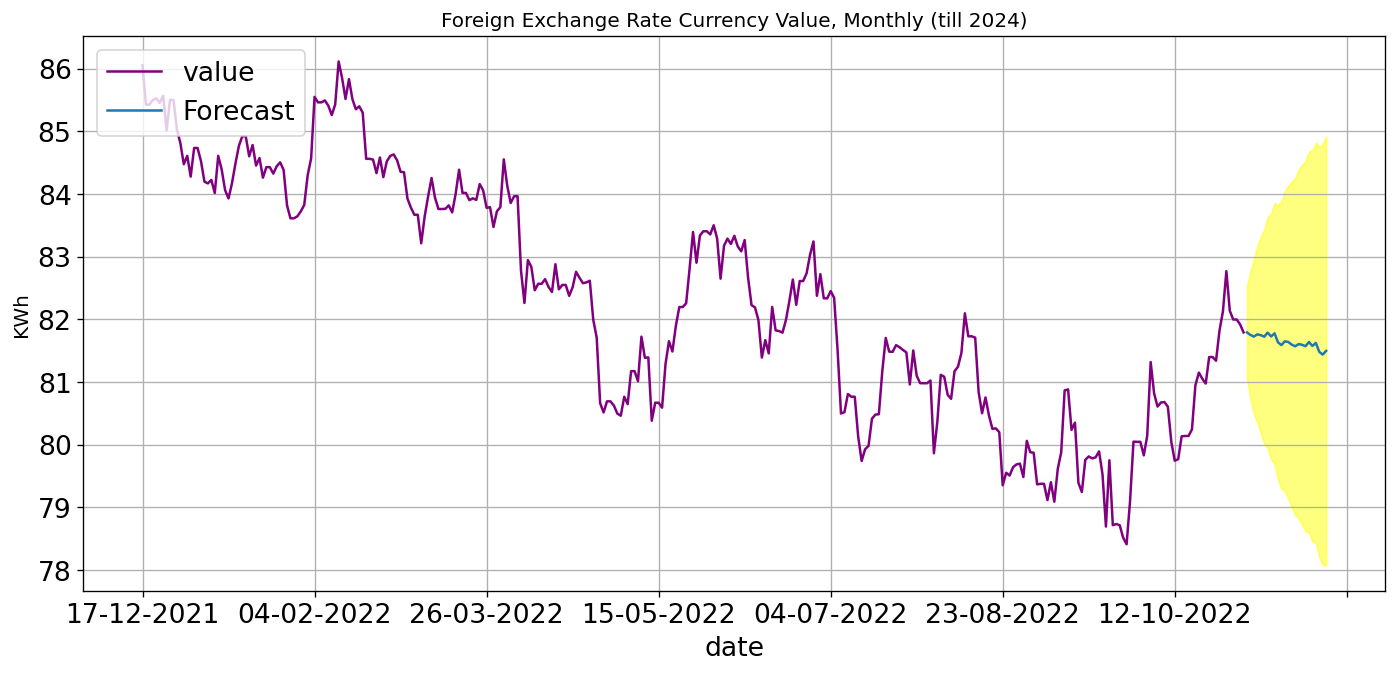

In [281]:
#Forecasting 2 years ahead
forecast_values = model.get_forecast(steps = 24)

INR_dataset = df.loc[df.currency == 'INR']

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = INR_dataset.plot(x='date', y='value', figsize = (14, 6), legend = True, color='purple')

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='yellow', alpha = .5)
plt.title('Foreign Exchange Rate Currency Value, Monthly (till 2024)', size = 12)
plt.ylabel('KWh', size=12)
plt.legend(loc='upper left')
ax.axes.get_xaxis().set_visible(True)

plt.show()

Conclusion: From all the models I have tried the XGB regression was the best with R2 score around 93 none of the other models have score greater than 90 the SARIMA also have the score of 81 only.